# Shampine Gordon Watts Adams method & Van der Pol's equation

The `SWAG` solver is demonstrated on the Van der Pol equation (E2 from the [DETEST](https://perso.ensta-paris.fr/~chapoutot/integration/docs/p1-enright.pdf) set). The benefits of this explicit method for non-stiff problems and its main drawback are discussed.

## Problem definition

The initial value problem is:

In [1]:
problem = {'fun' : lambda x, y: [y[1], (1-y[0]**2)*y[1] - y[0]],
            'y0' : [2., 0.],
        't_span' : [0., 20.]}

## Reference solution

First, a reference solution is created by solving this problem with low tolerance using Bogacki Shampine's fifth order Runge Rutta method `BS45`. This method has an accurate interpolant for dense output. The error of the interpolated solution is as accurate as the nearest solution points themselves. This is very convenient for a reference solution.

In [2]:
from scipy.integrate import solve_ivp
from extensisq import BS45

reference = solve_ivp(**problem, atol=1e-12, rtol=1e-12, method=BS45, dense_output=True)

## Solution plot

The plot below shows the solution. It is a limit cycle with rapid changes in the slopes of the curves.

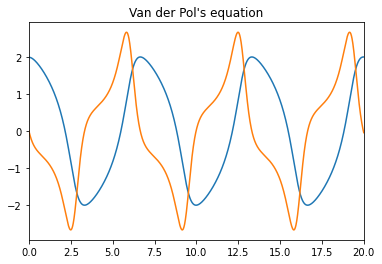

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

t = np.linspace(*problem['t_span'])

plt.figure()
plt.plot(reference.t, reference.y.T)
plt.title("Van der Pol's equation")
plt.xlim(problem['t_span'])
plt.show()

## Efficiency plot

The efficiency of the methods can be assessed by making a plot of the error versus the number of derivative function evaluations. The error is calculated by the RMS norm:

In [4]:
def rms_err_norm(solution, reference):
    error = solution.y - reference.sol(solution.t)
    err_norm = (error**2).mean()**0.5
    return err_norm

Let's solve this problem with `SWAG`, and Scipy's methods `RK45`, `DOP853` and `LSODA`. The `LSODA` contains an Adams method as well (and also a BDF method). Solving at several tolerance values and comparing the errors gives an idea about the efficiency of the methods.

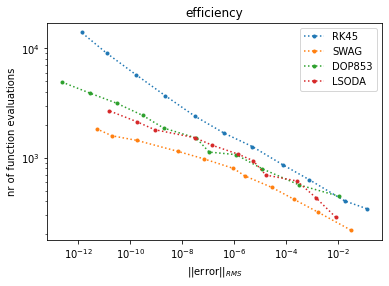

In [5]:
from scipy.integrate import solve_ivp
from extensisq import SWAG

methods = ['RK45', SWAG, 'DOP853', 'LSODA']
tolerances = np.logspace(-2, -12, 11)

plt.figure()
for method in methods:
    name = method if isinstance(method, str) else method.__name__
    e = []
    n = []
    for tol in tolerances:
        sol = solve_ivp(**problem, rtol=1e-13, atol=tol, method=method)
        err = rms_err_norm(sol, reference)
        e.append(err)
        n.append(sol.nfev)
    plt.loglog(e, n, ':.', label=name)
plt.legend()
plt.xlabel(r'||error||$_{RMS}$')
plt.ylabel('nr of function evaluations')
plt.title('efficiency')
plt.show()    

## Discussion

* The `SWAG` method needs fewer evaluations for this problem than the three compared Scipy methods for each error level.
* Both `LSODA` an `SWAG` have curved efficiency lines in the above plot. The order is automatically increased when tighter tolerences are requested. I think that this is a very useful property of these variable order methods.
* No dense output was requested. Multistep methods like `SWAG` take much smaller steps than (high order) Runge Kutta methods. Therefore, dense output may not be needed as often. Nevertheless, when it is needed, `SWAG` has a accurate, 'free' and C1-continuous interpolant. By comparison, `RK45`'s dense output is less accurate (although typically accurate enough), `DOP853`'s dense output is not free (extra function evaluations are needed), and `LSODA`'s is discontinuous at order 1 (used at startup for example).
* A rejected step in `SWAG` costs only one function evaluation. Step rejection is much more costly for high order Runge Kutta methods. For this reason `BS45` and `BS45_i` contain an extra error estimate that can reject a step before all evaluations are done. (The same holds for `CK45`, but these error estimates are intended to detect discontinuities.) Multistep methods such as `SWAG` are inherently superior in this aspect.
* Not all is positive though for `SWAG`. Its main drawback is that it has has considerable overhead. Coefficients must be updated after step size changes. The stepsize strategy aims to keep stepsize constant for many steps, and the code minimizes the computational effort needed for such updates. Despite these mitigations, `SWAG`, and multistep methods in general, are typically recommended for problems with expensive derivative function evaluations, such that this overhead is compensated by the fewer function evaluations. On the other hand, when the derivative function is very cheap to evaluate, and the problems takes less than a second to solve, the mentioned benefits of `SWAG` may still outweigh the cost of overhead.

In short, the `SWAG` method has several benefits for solving non-stiff problems. It is particulary useful for problems with  computationally expensive derivative function evaluations.